In [1]:
%load_ext autoreload
%autoreload
import os
import numpy as np

import pyrender 
import trimesh
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pyquaternion import Quaternion

## Superquadrics

A thorough overview of superquadrics: https://cse.buffalo.edu/~jryde/cse673/files/superquadrics.pdf

<!-- ### Implicit Equation
The surface of a basic superquadric is given by: 
$$ \vert x \vert^r + \vert y \vert^s + \vert z \vert^t = 1 ,$$

where $r, s$ and $t$ are positive real numbers that determine the main features of the superquadric:
 - $< 1$ : pointy octahedron
 - $= 1$: regular octahedron
 - $range(1, 2)$: blunt octahedron
 - $=2$ : sphere
 - $>2$ : cube modified to have rounded edges and corners
 
 We can scale these basic shapes as follows: 
 
 $$ \vert \frac{x}{A} \vert^r + \vert \frac{y}{B} \vert^s + \vert \frac{z}{C} \vert^t = 1 $$


### Parametric description

We can describe a superquadric with a parametric equation in terms of surface parameters u (longitude) and v (latitude) by:

\begin{align}
& x(u,v) = Ag\left(v, \frac{2}{r}\right)g\left(u, \frac{2}{r}\right) \\
& y(u,v) = Bg\left(v, \frac{2}{s}\right)f\left(u, \frac{2}{s}\right) \\
& z(u,v) = Cf\left(v, \frac{2}{t}\right) \\
& -\frac{\pi}{2} \leq v \leq \frac{\pi}{2}, \quad -\pi \leq u \leq \pi
\end{align}

The auxilary functions $f$ and $g$ are:

\begin{align}
& f(\omega, m) = sgn(\sin \omega) \vert \sin \omega \vert^m \\
& f(\omega, m) = sgn(\cos \omega) \vert \cos \omega \vert^m \\
\end{align}

where $sgn(x)$ is the sign function (-1 if x < 0, 0 if x == 0, 1 if x > 0)  --> 

In [23]:
def render_one_img(shape):
    mesh_node = pyrender.Mesh.from_trimesh(shape)
    scene = pyrender.Scene(ambient_light=[500, 500, 500, 1000])
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
    #light = pyrender.PointLight(color=[100.0, 100.0, 100.0], intensity=10.0)

    c = 2**-0.5
    pose = [[ 1,  0,  0,  0],
            [ 0,  c, -c, -3],
            [ 0,  c,  c,  3],
            [ 0,  0,  0,  1]]
    
    scene.add(mesh_node, pose=np.eye(4))
    #scene.add(light, pose=np.eye(4))
    scene.add(camera, pose=pose)

    
    r = pyrender.OffscreenRenderer(640, 480)
    color, depth = r.render(scene)

    fig = plt.figure()
    plt.axis('off')
    plt.imshow(color)
    
    return fig, shape

In [24]:
def render_img(shape, img_dir, n_frames):
    mesh_node = pyrender.Mesh.from_trimesh(shape)
    scene = pyrender.Scene(ambient_light=[500, 500, 500, 1000])
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
    #light = pyrender.PointLight(color=[100.0, 100.0, 100.0], intensity=10.0)

    c = 2**-0.5
    pose = [[ 1,  0,  0,  0],
         [ 0,  c, -c, -3],
         [ 0,  c,  c,  3],
         [ 0,  0,  0,  1]]

    mesh_node = scene.add(mesh_node, pose=np.eye(4), name='mesh')
    #scene.add(light, pose=np.eye(4))
    camera_node = scene.add(camera, pose=pose)

    r = pyrender.OffscreenRenderer(640, 480)
    rotation_axis = np.random.uniform(-1, 1, size=3)

    fig = plt.figure()
    i = 0
#     q0 = Quaternion(axis=rotation_axis, degrees=0.0) # Rotate 0 about x=y=z
#     q1 = Quaternion(axis=rotation_axis, degrees=180) # Rotate 120 about x=y=z
#     q2 = Quaternion(axis=rotation_axis, degrees=360)
    degrees = np.linspace(0, 360, n_frames)
    for d in tqdm(degrees):
        q = Quaternion(axis=rotation_axis, degrees=d)
        node = list(scene.get_nodes(name='mesh'))[0]
        scene.set_pose(node, q.transformation_matrix)
        print('Rotation matrix: \n{}\nTransformation matrix: \n{}\nElements: {}\nAngle: {}\n\n'.format(
            q.rotation_matrix, q.transformation_matrix,  q.elements, q.angle))
        color, depth = r.render(scene)
        plt.imshow(color)

        plt.axis('off')

#         plt.savefig(img_dir + '/fig_%d.png'%i)
        i += 1
        plt.clf()
    
    plt.close()
    r.delete()

    return fig, shape

In [4]:
shape = trimesh.load('test.obj')

#scene = pyrender.Scene.from_trimesh_scene(shape)

faces have mixed data, using slow fallback!


faces have mixed data, using slow fallback!


(<Figure size 432x288 with 1 Axes>,
 <trimesh.Trimesh(vertices.shape=(4142, 3), faces.shape=(7936, 3))>)

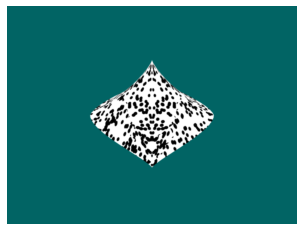

In [22]:
shape = trimesh.load('objects/scene_101/scene.obj')
render_img(shape, 'objects/scene_101/images/', 200)

In [131]:
shape = trimesh.load('objects/scene_101/textured.obj')
mesh_node = pyrender.Mesh.from_trimesh(shape)
scene = pyrender.Scene(ambient_light=[500, 500, 500, 1000])
#camera = pyrender.PerspectiveCamera(yfov=np.pi / 4.0)
#light = pyrender.PointLight(color=[100.0, 100.0, 100.0], intensity=10.0)

c = 2**-0.5
pose = [[ 1,  0,  0,  0],
        [ 0,  c, -c, -3],
        [ 0,  c,  c,  3],
        [ 0,  0,  0,  1]]

scene.add(mesh_node, pose=np.eye(4), name='mesh')
shape.vertices = shape.vertices.dot(Quaternion(axis=[.1, .1, .1], degrees=1).rotation_matrix)
mesh_node = list(scene.get_nodes(name='mesh'))[0]
print(mesh_node)
r = mesh_node.rotation
t = mesh_node.translation
m = mesh_node.matrix
print(r,t,m)
#scene.add(light, pose=np.eye(4))
#scene.add(camera, pose=pose)
pyrender.Viewer(scene)

faces have mixed data, using slow fallback!


[0. 0. 0. 1.] [0. 0. 0.] [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


GLError: GLError(
	err = 1281,
	description = b'invalid value',
	baseOperation = glDeleteProgram,
	cArguments = (3,)
)

GLException: b'invalid framebuffer operation'

In [3]:
def render_file(obj_file):
    shape = trimesh.load(obj_file)
    return render_img(shape)

faces have mixed data, using slow fallback!


(<Figure size 432x288 with 1 Axes>,
 <trimesh.Trimesh(vertices.shape=(2744, 3), faces.shape=(7936, 3))>)

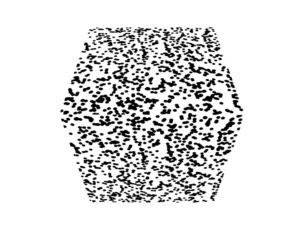

In [19]:
render_file('objects/scene_006/textured.obj')

(<Figure size 432x288 with 1 Axes>,
 <trimesh.Trimesh(vertices.shape=(1488900, 3), faces.shape=(3126660, 3))>)

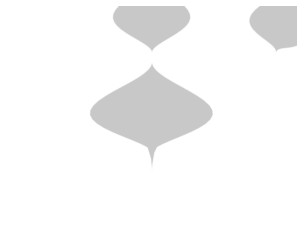

In [5]:
shape = trimesh.load('pyquadrics/all_superellipsoids.obj')

In [113]:
def create_vid(base_dir, output_name, frame_rate=25):
    ffmpeg_cmd = 'ffmpeg -framerate {} -i {}/images/fig_%d.png -vf format=yuv420p {}/{}'.format(frame_rate, base_dir, base_dir, output_name)
    print(ffmpeg_cmd)
    res = os.system(ffmpeg_cmd)
    print(res)

In [114]:
create_vid('objects', 'vid.mp4')

ffmpeg -framerate 25 -i objects/images/fig_%d.png -vf format=yuv420p objects/vid.mp4
256


faces have mixed data, using slow fallback!


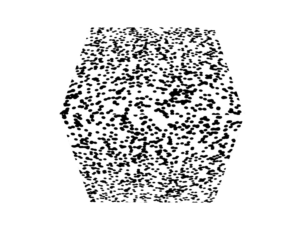

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_007/images/fig_%d.png -vf format=yuv420p objects/scene_007/vid.mp4


faces have mixed data, using slow fallback!


0


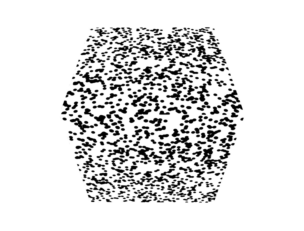

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_008/images/fig_%d.png -vf format=yuv420p objects/scene_008/vid.mp4


faces have mixed data, using slow fallback!


0


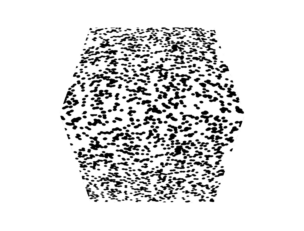

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_009/images/fig_%d.png -vf format=yuv420p objects/scene_009/vid.mp4


faces have mixed data, using slow fallback!


0


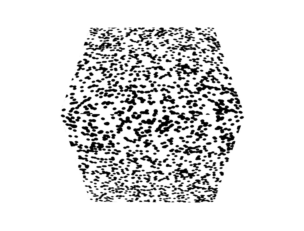

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_010/images/fig_%d.png -vf format=yuv420p objects/scene_010/vid.mp4


faces have mixed data, using slow fallback!


0


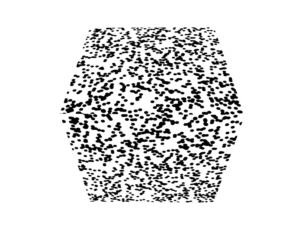

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_011/images/fig_%d.png -vf format=yuv420p objects/scene_011/vid.mp4


faces have mixed data, using slow fallback!


0


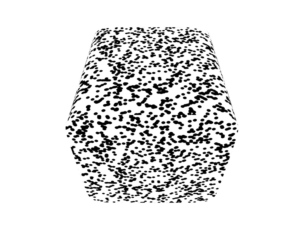

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_012/images/fig_%d.png -vf format=yuv420p objects/scene_012/vid.mp4


faces have mixed data, using slow fallback!


0


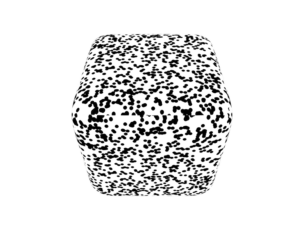

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_013/images/fig_%d.png -vf format=yuv420p objects/scene_013/vid.mp4


faces have mixed data, using slow fallback!


0


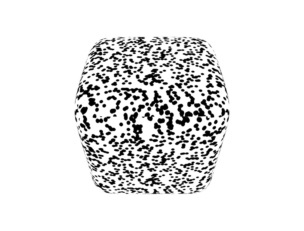

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_014/images/fig_%d.png -vf format=yuv420p objects/scene_014/vid.mp4


faces have mixed data, using slow fallback!


0


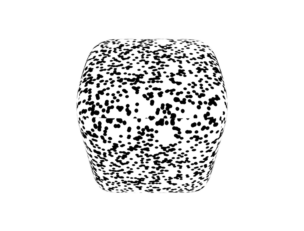

faces have mixed data, using slow fallback!



ffmpeg -framerate 25 -i objects/scene_015/images/fig_%d.png -vf format=yuv420p objects/scene_015/vid.mp4


faces have mixed data, using slow fallback!


0


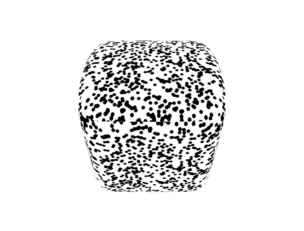

faces have mixed data, using slow fallback!


ValueError: Failed to initialize Pyglet window with an OpenGL >= 3+ context. If you're logged in via SSH, ensure that you're running your script with vglrun (i.e. VirtualGL). The internal error message was "list index out of range"

In [21]:
n_scenes = 143
n_frames = 200
for scene in range(7, n_scenes):
    base_dir = 'objects/scene_%03d'%scene
    obj_file = base_dir + '/textured.obj'

    fig = render_file(obj_file)
    plt.show(fig)

    shape = trimesh.load(obj_file)
    img_dir = os.path.join(base_dir, 'images')
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    for i in tqdm(range(n_frames)):
        shape.vertices = shape.vertices.dot(Quaternion(axis=[.1, .1, .1], degrees=1).rotation_matrix)
        fig, shape = render_img(shape)
        plt.savefig(img_dir + '/fig_%d.png'%i)
        plt.close()

    create_vid(base_dir, 'vid.mp4')

In [12]:
shape = trimesh.load(obj_file)
img_dir = os.path.join(base_dir, 'images')
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

for i in tqdm(range(200)):
    shape.vertices = shape.vertices.dot(Quaternion(axis=[.1, .1, .1], degrees=1).rotation_matrix)
    fig, shape = render_img(shape)
    plt.savefig(img_dir + '/fig_%d.png'%i)
    plt.close()

faces have mixed data, using slow fallback!


In [13]:
def create_vid(base_dir, output_name, frame_rate=25):
    ffmpeg_cmd = 'ffmpeg -framerate {} -i {}/images/fig_%d.png -vf format=yuv420p {}/{}'.format(frame_rate, base_dir, base_dir, output_name)
    print(ffmpeg_cmd)
    res = os.system(ffmpeg_cmd)
    print(res)

In [14]:
create_vid(base_dir, 'vid.mp4')

ffmpeg -framerate 25 -i objects/scene_0/images/fig_%d.png -vf format=yuv420p objects/scene_0/vid.mp4
0


### Generating a variety of superellipses

In [8]:
x_scale = 1
y_scale = 1
z_scale = 1

i = 0
for e1 in np.arange(0, 4.25, 0.25):
    for e2 in np.arange(e2, 4, 0.25):
        epsilons = [e1, e2]
        shape = shapes.Ellipsoid(x_scale, y_scale, z_scale, epsilons)
        fname = 'objects/superellipse_({}, {}).ply'.format(e1, e2)
        shape.save_as_mesh(fname)

Generated / Trimesh faces: (12, 3), (12, 3) ... Generated / Trimesh Vertices: (3, 10000), (8, 3) 
Generated / Trimesh faces: (796, 3), (796, 3) ... Generated / Trimesh Vertices: (3, 10000), (400, 3) 
Generated / Trimesh faces: (796, 3), (796, 3) ... Generated / Trimesh Vertices: (3, 10000), (400, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (784, 3), (784, 3) ... Generated / Trimesh Vertices: (3, 10000), (394, 3) 
Generated / Trimesh faces: (16, 3), (16, 3) ... Generated / Trimesh Vertices: (3, 10000), (10, 3) 
Generated / Trimesh faces: (16, 3), (16, 3) ... Generated / Trimesh Vertices: (3, 10000),

Generated / Trimesh faces: (19404, 3), (19404, 3) ... Generated / Trimesh Vertices: (3, 10000), (9704, 3) 
Generated / Trimesh faces: (19404, 3), (19404, 3) ... Generated / Trimesh Vertices: (3, 10000), (9704, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Vertices: (3, 10000), (200, 3) 
Generated / Trimesh faces: (396, 3), (396, 3) ... Generated / Trimesh Ve

In [4]:
idxs = [0, 1, 4, 5, 7, 10]
for idx in idxs:
    fname = 'objects/superellipse_%d.ply'%idx
    mesh = trimesh.load(fname)
    print(mesh.faces.shape, mesh.vertices.shape)
    render('objects/superellipse_%d.ply'%idx)

(12, 3) (8, 3)
(796, 3) (400, 3)
(784, 3) (394, 3)
(784, 3) (394, 3)
(784, 3) (394, 3)
(55314, 3) (9415, 3)


In [7]:
R

array([[-0.5924839 , -0.79265904, -0.14371667],
       [-0.05003803,  0.21426772, -0.97549246],
       [ 0.80402676, -0.57077228, -0.16661327]])

### Generating a variety of supertoroids

In [11]:
x_scale = 2
y_scale = 2
z_scale = 2
inner_radius = 2

i = 0
for e2 in np.arange(0, 2.75, 0.25):
    for e1 in np.arange(0, 2.75, 0.25):
        epsilons = [e1, e2]
        shape = shapes.Toroid(x_scale, y_scale, z_scale, inner_radius, epsilons)
        fname = 'objects/supertoroid_%d.ply'%i
        shape.save_as_mesh(fname)
        i += 1

### SuperEgg

In [6]:
x_scale = 3
y_scale = 3
z_scale = 4
eps = [.8, 1]
shape = shapes.Ellipsoid(x_scale, y_scale, z_scale, eps)
shape.save_as_mesh('objects/superegg.ply')
render('objects/superegg.ply')

In [164]:
def plot3d(shape):
    fig = go.Figure(data=[go.Scatter3d(x=shape[0, :], y=shape[1, :], z=shape[2, :], mode='markers')])
    fig.show()

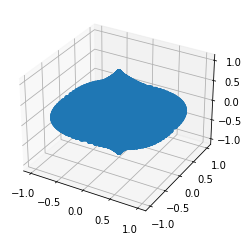

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

points = s_ellipse.points
ax.scatter(points[0, :], points[1, :], points[2, :])

In [172]:
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

In [147]:
ellip_double.shape

(27, 23, 35)

In [175]:
a = np.random.randint(0, 100, size=(3, 1000))

In [185]:
b = np.array(np.split(a, 3))

In [187]:
b = np.array([a[0, :], a[1, :], a[2, :]])

In [188]:
b.shape

(3, 1000)

In [148]:
ellip = shapes.Ellipsoid(1,1,1,[0,0])

In [154]:
points = np.concatenate([ellip.points[0, :], ellip.points[1, :], ellip.points[2, :]])

In [155]:
points.shape

(30000,)

In [166]:
ellip = shapes.ellipsoid_points(1,1,1,.2,.2, levelset=True)

In [167]:
plot3d(ellip)